### Notebook for assorted analysis for meoscale organisation project

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.distributed import Client, LocalCluster
import warnings
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point, MultiPoint, LineString
import shapely

In [2]:
try:
    client
except:
    cluster = LocalCluster()
    client = Client(cluster)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37367 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37367/status,
Dashboard: /proxy/37367/status,Workers: 7
Total threads: 7,Total memory: 256.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41163,Workers: 7
Dashboard: /proxy/37367/status,Total threads: 7
Started: Just now,Total memory: 256.00 GiB
Comm: tcp://127.0.0.1:35435,Total threads: 1
Dashboard: /proxy/33157/status,Memory: 36.57 GiB
Nanny: tcp://127.0.0.1:35013,


### Load IMERG data

In [3]:
%%time
imerg_path = '/g/data/k10/cb4968/metrics/observations/IMERG/small_domain/pr_based/IMERG/pr_based_IMERG_3hrly_0-360_-30-30_3600x1800_2001-01_2023-12_boxsize_5/'
imerg_data = xr.open_mfdataset(imerg_path+'*.nc')
imerg_data

0.3.0
CPU times: user 17.1 s, sys: 7.33 s, total: 24.4 s
Wall time: 1min 16s


<xarray.Dataset>
Dimensions:                 (time: 67149, lat: 12, lon: 72)
Coordinates:
  * time                    (time) datetime64[ns] 2001-01-01 ... 2023-12-31T2...
  * lon                     (lon) float64 2.5 7.5 12.5 ... 347.5 352.5 357.5
  * lat                     (lat) float64 -27.5 -22.5 -17.5 ... 17.5 22.5 27.5
Data variables:
    pr_based_mean_pr        (time, lat, lon) float32 dask.array<chunksize=(248, 12, 72), meta=np.ndarray>
    pr_based_max_pr_30min   (time, lat, lon) float64 dask.array<chunksize=(248, 12, 72), meta=np.ndarray>
    pr_based_area_fraction  (time, lat, lon) float64 dask.array<chunksize=(248, 12, 72), meta=np.ndarray>
    pr_based_mean_area      (time, lat, lon) float64 dask.array<chunksize=(248, 12, 72), meta=np.ndarray>
    pr_based_N              (time, lat, lon) float64 dask.array<chunksize=(248, 12, 72), meta=np.ndarray>
    pr_based_nCores         (time, lat, lon) float64 dask.array<chunksize=(248, 12, 72), meta=np.ndarray>
    pr_based_Iorg           (time, lat, lon) float64 dask.array<chunksize=(248, 12, 72), meta=np.ndarray>

In [4]:
%%time

pr_based_mean_pr = imerg_data['pr_based_mean_pr']
pr_based_Iorg = imerg_data['pr_based_Iorg']
pr_based_max_pr_30min = imerg_data['pr_based_max_pr_30min']
pr_based_mean_area = imerg_data['pr_based_mean_area']

pr_based_mean_pr

CPU times: user 164 µs, sys: 0 ns, total: 164 µs
Wall time: 175 µs


<xarray.DataArray 'pr_based_mean_pr' (time: 67149, lat: 12, lon: 72)>
dask.array<concatenate, shape=(67149, 12, 72), dtype=float32, chunksize=(248, 12, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 ... 2023-12-31T21:00:00
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * lat      (lat) float64 -27.5 -22.5 -17.5 -12.5 -7.5 ... 12.5 17.5 22.5 27.5

In [5]:
%%time

# further operations to IMERG data
# 1. rename lat/lon and move to -180 to +180 lon grid
# 2. take daily means of quantities
# 3. load into memory

pr_based_mean_pr = pr_based_mean_pr.rename({'lat': 'latitude', 'lon': 'longitude'})
pr_based_mean_pr = pr_based_mean_pr.resample(time='1D').mean()
pr_based_mean_pr = pr_based_mean_pr.compute()
pr_based_mean_pr['longitude'] = (pr_based_mean_pr.coords['longitude'] + 180) % 360 - 180
pr_based_mean_pr = pr_based_mean_pr.sortby(pr_based_mean_pr.longitude)

pr_based_mean_area = pr_based_mean_area.rename({'lat': 'latitude', 'lon': 'longitude'})
pr_based_mean_area = pr_based_mean_area.resample(time='1D').mean()
pr_based_mean_area = pr_based_mean_area.compute()
pr_based_mean_area['longitude'] = (pr_based_mean_area.coords['longitude'] + 180) % 360 - 180
pr_based_mean_area = pr_based_mean_area.sortby(pr_based_mean_area.longitude)

pr_based_max_pr_30min = pr_based_max_pr_30min.rename({'lat': 'latitude', 'lon': 'longitude'})
pr_based_max_pr_30min = pr_based_max_pr_30min.resample(time='1D').mean()
pr_based_max_pr_30min = pr_based_max_pr_30min.compute()
pr_based_max_pr_30min['longitude'] = (pr_based_max_pr_30min.coords['longitude'] + 180) % 360 - 180
pr_based_max_pr_30min = pr_based_max_pr_30min.sortby(pr_based_max_pr_30min.longitude)

pr_based_Iorg = pr_based_Iorg.rename({'lat': 'latitude', 'lon': 'longitude'})
pr_based_Iorg = pr_based_Iorg.resample(time='1D').mean()
pr_based_Iorg = pr_based_Iorg.compute()
pr_based_Iorg['longitude'] = (pr_based_Iorg.coords['longitude'] + 180) % 360 - 180
pr_based_Iorg = pr_based_Iorg.sortby(pr_based_Iorg.longitude)

CPU times: user 10.4 s, sys: 2.29 s, total: 12.7 s
Wall time: 15.4 s


### Load weather objects

In [35]:
%%time
def load_tracks_csv(path):
    tracks = pd.read_csv(path, index_col=['scan','uid'])
    # convert geometry from string to shapely polygons
    tracks['geometry'] = gpd.GeoSeries.from_wkt(tracks['geometry'])
    tracks = gpd.GeoDataFrame(tracks, geometry='geometry')
    tracks = tracks.set_index([tracks.index.get_level_values(0),tracks.index.get_level_values(1).astype(int)])
    # convert to datetime
    tracks['time'] = pd.to_datetime(tracks['time'])
    
    # filter time to line up with IMERG
    tracks = tracks[tracks['time'] >= '2001-01-01']

    tracks = tracks.reset_index().set_index(['time', 'uid'])
    return tracks


wet_pert_tracks = load_tracks_csv('/g/data/k10/cr7888/tracks/wet_objects/wet_tracks_45_smooth_bg_90_nodup_properties.csv')
dry_pert_tracks = load_tracks_csv('/g/data/k10/cr7888/tracks/dry_objects/dry_tracks_45_smooth_bg_90_nodup_properties.csv')

MJO_wet_tracks = load_tracks_csv('/g/data/k10/cr7888/tracks/eq_waves/MJO_wet_tracks_ext_nodup.csv')
MJO_dry_tracks = load_tracks_csv('/g/data/k10/cr7888/tracks/eq_waves/MJO_dry_tracks_ext_nodup.csv')
ER_wet_tracks = load_tracks_csv('/g/data/k10/cr7888/tracks/eq_waves/ER_wet_tracks_ext_nodup.csv')
ER_dry_tracks = load_tracks_csv('/g/data/k10/cr7888/tracks/eq_waves/ER_dry_tracks_ext_nodup.csv')
Kelvin_wet_tracks = load_tracks_csv('/g/data/k10/cr7888/tracks/eq_waves/Kelvin_wet_tracks_ext_nodup.csv')
Kelvin_dry_tracks = load_tracks_csv('/g/data/k10/cr7888/tracks/eq_waves/Kelvin_dry_tracks_ext_nodup.csv')

pv_cyc_350K_tracks = load_tracks_csv('/g/data/k10/cr7888/tracks/PV_objects/PV_cyc_objects_350K_depth_new.csv')
pv_acyc_350K_tracks = load_tracks_csv('/g/data/k10/cr7888/tracks/PV_objects/PV_acyc_objects_350K_ext_nodup.csv')

CPU times: user 33.7 s, sys: 1.28 s, total: 35 s
Wall time: 35.4 s


**Monsoon low pressure system dataset**

In [7]:
%%time

LPS_file = open('/g/data/k10/cr7888/global_monsoon_LPS/LPS_Global_ERA5.dat')

id = -1
LPS_data = []

for line in LPS_file.readlines():

    # check if line starts with "start" to denote a new track
    if line.startswith('start'):
        # if id == 1000:
        #     break

        id += 1 
    else:

        LPS_data.append([id] + [float(i) for i in line.strip().split('\t')])

LPS_df = pd.DataFrame(LPS_data, columns=['id', 'x', 'y', 'lon', 'lat', 'psi', 'mslp', 'pres_drop', 'maxwind', 'rh', 'z_surf', 'land_mask', 'ACEPSL', 'ACE', 'PDI', 'IKE', 'year', 'month', 'day', 'hour'])
LPS_df[['x', 'y', 'year', 'month', 'day', 'hour']] = LPS_df[['x', 'y', 'year', 'month', 'day', 'hour']].astype(int)
times = pd.to_datetime(LPS_df[['year', 'month', 'day', 'hour']])
LPS_df['time'] = times
# convert to +/- 180 deg
LPS_df['lon'] = (LPS_df['lon']  + 180) % 360 - 180
LPS_df = LPS_df.drop(columns=['year', 'month', 'day', 'hour'])
LPS_df = LPS_df.set_index(['id','time'])

LPS_df = LPS_df.loc[(slice(None), LPS_df.index.levels[1][LPS_df.index.levels[1].hour == 12]), :] # only 12 UTC
LPS_df

CPU times: user 27.3 s, sys: 2.06 s, total: 29.4 s
Wall time: 29 s


x    y     lon    lat         psi       mslp  \
id    time                                                                   
0     1979-01-01 12:00:00   673  346  168.25   3.50 -12634820.0  100259.60   
      1979-01-02 12:00:00   672  335  168.00   6.25  -9764064.0  100081.20   
      1979-01-03 12:00:00   672  327  168.00   8.25  -9061234.0   99892.19   
      1979-01-04 12:00:00   665  323  166.25   9.25 -11851910.0   99620.75   
      1979-01-05 12:00:00   653  320  163.25  10.00 -11994600.0   99726.81   
...                         ...  ...     ...    ...         ...        ...   
20407 2019-12-29 12:00:00   238  435   59.50 -18.75   5086305.0   99814.49   
      2019-12-30 12:00:00   232  444   58.00 -21.00   7995798.0   99185.47   
      2019-12-31 12:00:00   234  450   58.50 -22.50   7476790.0   98823.54   
20408 2019-12-30 12:00:00  1186  489  -63.50 -32.25  -2645836.0  100661.20   
      2019-12-31 12:00:00  1212  500  -57.00 -35.00   2242256.0  100468.10   

                           pres_drop    maxwind        rh        z_surf  \
id    time                                                                
0     1979-01-01 12:00:00   377.5000  12.600450  84.83293      5.312450   
      1979-01-02 12:00:00   413.0000  14.553330  88.58506      6.210389   
      1979-01-03 12:00:00   643.0000  14.642070  84.20066      5.312450   
      1979-01-04 12:00:00   921.7500  17.438590  91.74026      5.312450   
      1979-01-05 12:00:00   922.7500  17.106860  91.62795      7.108329   
...                              ...        ...       ...           ...   
20407 2019-12-29 12:00:00   870.2500  17.249030  88.07535     58.290870   
      2019-12-30 12:00:00  1556.2810  16.276600  89.20706   1080.146000   
      2019-12-31 12:00:00  1913.3200  20.931740  92.00587     78.943480   
20408 2019-12-30 12:00:00   284.8359   6.630727  82.59852  13661.170000   
      2019-12-31 12:00:00   416.3984  11.897640  91.05245   2083.144000   

                           land_mask    ACEPSL       ACE         PDI  \
id    time                                                             
0     1979-01-01 12:00:00   0.000000  0.163765  0.013000   201.81650   
      1979-01-02 12:00:00   0.000000  0.190884  0.007461    87.74224   
      1979-01-03 12:00:00   0.000000  0.221910  0.010983   156.71070   
      1979-01-04 12:00:00   0.000000  0.266397  0.018362   338.76010   
      1979-01-05 12:00:00   0.000000  0.249617  0.041111  1134.90500   
...                              ...       ...       ...         ...   
20407 2019-12-29 12:00:00   0.000000  0.230318  0.017460   314.12170   
      2019-12-30 12:00:00   0.000000  0.348269  0.043930  1253.59700   
      2019-12-31 12:00:00   0.000000  0.413602  0.074464  2766.55900   
20408 2019-12-30 12:00:00   0.999145  0.103886  0.011004   157.16830   
      2019-12-31 12:00:00   0.000092  0.131097  0.014777   244.56220   

                                    IKE  
id    time                               
0     1979-01-01 12:00:00  2.531821e+10  
      1979-01-02 12:00:00  1.706158e+10  
      1979-01-03 12:00:00  2.748241e+10  
      1979-01-04 12:00:00  4.949122e+10  
      1979-01-05 12:00:00  9.330928e+10  
...                                 ...  
20407 2019-12-29 12:00:00  4.342575e+10  
      2019-12-30 12:00:00  8.593410e+10  
      2019-12-31 12:00:00  1.555459e+11  
20408 2019-12-30 12:00:00  2.156938e+10  
      2019-12-31 12:00:00  3.938732e+10  

[73348 rows x 15 columns]

### Calculate IMERG properties by weather system

These functions iterate over each time step, find objects at that time, and filter the IMERG data to those associated with the weather objects. Values not assocaited with the weather object are set to NaN.

The 1st function is for area-based objects and the 2nd is for point-based objects (LPS)

In [8]:
def data_av_filter_obj(tracks, data, extend=0, dt=0):

    av = np.zeros(tracks.shape[0])

    data_filtered = data.copy()#deep=True)
    data_filtered.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    data_filtered.rio.write_crs("epsg:4326", inplace=True)

    for t, time in enumerate(data_filtered['time'].values):

        #print(time)
        try:
            geoms = tracks.xs(time+pd.Timedelta(dt, 'h'), level='time')['geometry'] #.floor('d')
            geoms_mp = MultiPolygon([poly.buffer(extend) for poly in geoms])
            filtered = data_filtered.sel(time=time).rio.clip(gpd.GeoSeries(geoms_mp), all_touched=True, drop=False)
            data_filtered[t,:,:] = filtered.values
        except KeyError:
            data_filtered[t,:,:] = np.nan
            continue

    print('done')
        
    return data_filtered


def data_av_filter_obj_point(tracks, data, extend=5, dt=12):
    """
    for LPS dataset
    """

    av = np.zeros(tracks.shape[0])

    data_filtered = data.copy()#deep=True)
    data_filtered.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    data_filtered.rio.write_crs("epsg:4326", inplace=True)

    for t, time in enumerate(data_filtered['time'].values):

        #print(t)

        try:
            lons = tracks.xs(time+pd.Timedelta(dt, 'h'), level='time')['lon'].values
            lats = tracks.xs(time+pd.Timedelta(dt, 'h'), level='time')['lat'].values
            geoms = gpd.GeoSeries([Point((lons[i], lats[i])) for i in range(lons.size)])
            geoms_mp = MultiPolygon([poly.buffer(extend) for poly in geoms])
            filtered = data_filtered.sel(time=time).rio.clip(gpd.GeoSeries(geoms_mp), all_touched=True, drop=False)
            data_filtered[t,:,:] = filtered.values
        except KeyError:
            data_filtered[t,:,:] = np.nan
            continue
    print('done')
        
    return data_filtered


In [33]:
%%time
wet_pert_av_precip = data_av_filter_obj(wet_pert_tracks, pr_based_mean_pr[::5,:,:], dt=12)

done
CPU times: user 25.6 s, sys: 2.18 s, total: 27.7 s
Wall time: 29 s


In [ ]:
assert False

In [36]:
%%time

# only use 20% of the data to save time. Using more/less doesn't make much difference

wet_pert_av_precip = data_av_filter_obj(wet_pert_tracks, pr_based_mean_pr[::5,:,:], dt=12)
dry_pert_av_precip = data_av_filter_obj(dry_pert_tracks, pr_based_mean_pr[::5,:,:], dt=12)
# MJO_dry_av_precip = data_av_filter_obj(MJO_dry_tracks, pr_based_mean_pr[::5,:,:])
# ER_wet_av_precip = data_av_filter_obj(ER_wet_tracks, pr_based_mean_pr[::5,:,:])
# ER_dry_av_precip = data_av_filter_obj(ER_dry_tracks, pr_based_mean_pr[::5,:,:])
# Kelvin_wet_av_precip = data_av_filter_obj(Kelvin_wet_tracks, pr_based_mean_pr[::5,:,:])
# Kelvin_dry_av_precip = data_av_filter_obj(Kelvin_dry_tracks, pr_based_mean_pr[::5,:,:])
# pv_cyc_av_precip = data_av_filter_obj(pv_cyc_350K_tracks, pr_based_mean_pr[::5,:,:], extend=5, dt=11)
# pv_acyc_av_precip = data_av_filter_obj(pv_acyc_350K_tracks, pr_based_mean_pr[::5,:,:], extend=5, dt=11)
# LPS_av_precip = data_av_filter_obj_point(LPS_df, pr_based_mean_pr[::5,:,:])

wet_pert_av_area = data_av_filter_obj(wet_pert_tracks, pr_based_mean_area[::5,:,:], dt=12)
dry_pert_av_area = data_av_filter_obj(dry_pert_tracks, pr_based_mean_area[::5,:,:], dt=12)
# MJO_wet_av_area = data_av_filter_obj(MJO_wet_tracks, pr_based_mean_area[::5,:,:])
# MJO_dry_av_area = data_av_filter_obj(MJO_dry_tracks, pr_based_mean_area[::5,:,:])
# ER_wet_av_area = data_av_filter_obj(ER_wet_tracks, pr_based_mean_area[::5,:,:])
# ER_dry_av_area = data_av_filter_obj(ER_dry_tracks, pr_based_mean_area[::5,:,:])
# Kelvin_wet_av_area = data_av_filter_obj(Kelvin_wet_tracks, pr_based_mean_area[::5,:,:])
# Kelvin_dry_av_area = data_av_filter_obj(Kelvin_dry_tracks, pr_based_mean_area[::5,:,:])
# pv_cyc_av_area = data_av_filter_obj(pv_cyc_350K_tracks, pr_based_mean_area[::5,:,:], extend=5, dt=11)
# pv_acyc_av_area = data_av_filter_obj(pv_acyc_350K_tracks, pr_based_mean_area[::5,:,:], extend=5, dt=11)
# LPS_av_area = data_av_filter_obj_point(LPS_df, pr_based_mean_area[::5,:,:])

wet_pert_av_maxprecip = data_av_filter_obj(wet_pert_tracks, pr_based_max_pr_30min[::5,:,:], dt=12)
dry_pert_av_maxprecip = data_av_filter_obj(dry_pert_tracks, pr_based_max_pr_30min[::5,:,:], dt=12)
# MJO_wet_av_maxprecip = data_av_filter_obj(MJO_wet_tracks, pr_based_max_pr_30min[::5,:,:])
# MJO_dry_av_maxprecip = data_av_filter_obj(MJO_dry_tracks, pr_based_max_pr_30min[::5,:,:])
# ER_wet_av_maxprecip = data_av_filter_obj(ER_wet_tracks, pr_based_max_pr_30min[::5,:,:])
# ER_dry_av_maxprecip = data_av_filter_obj(ER_dry_tracks, pr_based_max_pr_30min[::5,:,:])
# Kelvin_wet_av_maxprecip = data_av_filter_obj(Kelvin_wet_tracks, pr_based_max_pr_30min[::5,:,:])
# Kelvin_dry_av_maxprecip = data_av_filter_obj(Kelvin_dry_tracks, pr_based_max_pr_30min[::5,:,:])
# pv_cyc_av_maxprecip = data_av_filter_obj(pv_cyc_350K_tracks, pr_based_max_pr_30min[::5,:,:], extend=5, dt=11)
# pv_acyc_av_maxprecip = data_av_filter_obj(pv_acyc_350K_tracks, pr_based_max_pr_30min[::5,:,:], extend=5, dt=11)
# LPS_av_maxprecip = data_av_filter_obj_point(LPS_df, pr_based_max_pr_30min[::5,:,:])

wet_pert_av_Iorg = data_av_filter_obj(wet_pert_tracks, pr_based_Iorg[::5,:,:], dt=12)
dry_pert_av_Iorg = data_av_filter_obj(dry_pert_tracks, pr_based_Iorg[::5,:,:], dt=12)
# MJO_wet_av_Iorg = data_av_filter_obj(MJO_wet_tracks, pr_based_Iorg[::5,:,:])
# MJO_dry_av_Iorg = data_av_filter_obj(MJO_dry_tracks, pr_based_Iorg[::5,:,:])
# ER_wet_av_Iorg = data_av_filter_obj(ER_wet_tracks, pr_based_Iorg[::5,:,:])
# ER_dry_av_Iorg = data_av_filter_obj(ER_dry_tracks, pr_based_Iorg[::5,:,:])
# Kelvin_wet_av_Iorg = data_av_filter_obj(Kelvin_wet_tracks, pr_based_Iorg[::5,:,:])
# Kelvin_dry_av_Iorg = data_av_filter_obj(Kelvin_dry_tracks, pr_based_Iorg[::5,:,:])
# pv_cyc_av_Iorg = data_av_filter_obj(pv_cyc_350K_tracks, pr_based_Iorg[::5,:,:], extend=5, dt=11)
# pv_acyc_av_Iorg = data_av_filter_obj(pv_acyc_350K_tracks, pr_based_Iorg[::5,:,:], extend=5, dt=11)
# LPS_av_Iorg = data_av_filter_obj_point(LPS_df, pr_based_Iorg[::5,:,:])

MJO_wet_av_precip

done
done
done
done
done
done
done
done
CPU times: user 3min 18s, sys: 17.2 s, total: 3min 36s
Wall time: 3min 44s


<xarray.DataArray 'pr_based_mean_pr' (time: 1680, latitude: 12, longitude: 72)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude     (latitude) float64 -27.5 -22.5 -17.5 -12.5 ... 17.5 22.5 27.5
  * time         (time) datetime64[ns] 2001-01-01 2001-01-06 ... 2023-12-27
  * longitude    (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    spatial_ref  int64 0

### Creating arrays for box plots of IMERG quantities

Need to flatten arrays and remove NaNs

This is done for the 4 quantities (average precip, max precip, average area, Iorg)

In [38]:
wet_pert_av_precip_nonan = wet_pert_av_precip.values.flatten()
wet_pert_av_precip_nonan = wet_pert_av_precip_nonan[~np.isnan(wet_pert_av_precip_nonan)]

dry_pert_av_precip_nonan = dry_pert_av_precip.values.flatten()
dry_pert_av_precip_nonan = dry_pert_av_precip_nonan[~np.isnan(dry_pert_av_precip_nonan)]

MJO_wet_av_precip_nonan = MJO_wet_av_precip.values.flatten()
MJO_wet_av_precip_nonan = MJO_wet_av_precip_nonan[~np.isnan(MJO_wet_av_precip_nonan)]

MJO_dry_av_precip_nonan = MJO_dry_av_precip.values.flatten()
MJO_dry_av_precip_nonan = MJO_dry_av_precip_nonan[~np.isnan(MJO_dry_av_precip_nonan)]

ER_wet_av_precip_nonan = ER_wet_av_precip.values.flatten()
ER_wet_av_precip_nonan = ER_wet_av_precip_nonan[~np.isnan(ER_wet_av_precip_nonan)]

ER_dry_av_precip_nonan = ER_dry_av_precip.values.flatten()
ER_dry_av_precip_nonan = ER_dry_av_precip_nonan[~np.isnan(ER_dry_av_precip_nonan)]

Kelvin_wet_av_precip_nonan = Kelvin_wet_av_precip.values.flatten()
Kelvin_wet_av_precip_nonan = Kelvin_wet_av_precip_nonan[~np.isnan(Kelvin_wet_av_precip_nonan)]

Kelvin_dry_av_precip_nonan = Kelvin_dry_av_precip.values.flatten()
Kelvin_dry_av_precip_nonan = Kelvin_dry_av_precip_nonan[~np.isnan(Kelvin_dry_av_precip_nonan)]

pv_cyc_av_precip_nonan = pv_cyc_av_precip.values.flatten()
pv_cyc_av_precip_nonan = pv_cyc_av_precip_nonan[~np.isnan(pv_cyc_av_precip_nonan)]

pv_acyc_av_precip_nonan = pv_acyc_av_precip.values.flatten()
pv_acyc_av_precip_nonan = pv_acyc_av_precip_nonan[~np.isnan(pv_acyc_av_precip_nonan)]

LPS_av_precip_nonan = LPS_av_precip.values.flatten()
LPS_av_precip_nonan = LPS_av_precip_nonan[~np.isnan(LPS_av_precip_nonan)]

av_precip_nonan = [MJO_wet_av_precip_nonan, MJO_dry_av_precip_nonan, ER_wet_av_precip_nonan, 
                   ER_dry_av_precip_nonan, Kelvin_wet_av_precip_nonan, Kelvin_dry_av_precip_nonan,
                  pv_cyc_av_precip_nonan, pv_acyc_av_precip_nonan, LPS_av_precip_nonan, wet_pert_av_precip_nonan, dry_pert_av_precip_nonan]

In [41]:
wet_pert_av_maxprecip_nonan = wet_pert_av_maxprecip.values.flatten()
wet_pert_av_maxprecip_nonan = wet_pert_av_maxprecip_nonan[~np.isnan(wet_pert_av_maxprecip_nonan)]

dry_pert_av_maxprecip_nonan = dry_pert_av_maxprecip.values.flatten()
dry_pert_av_maxprecip_nonan = dry_pert_av_maxprecip_nonan[~np.isnan(dry_pert_av_maxprecip_nonan)]

MJO_wet_av_maxprecip_nonan = MJO_wet_av_maxprecip.values.flatten()
MJO_wet_av_maxprecip_nonan = MJO_wet_av_maxprecip_nonan[~np.isnan(MJO_wet_av_maxprecip_nonan)]

MJO_dry_av_maxprecip_nonan = MJO_dry_av_maxprecip.values.flatten()
MJO_dry_av_maxprecip_nonan = MJO_dry_av_maxprecip_nonan[~np.isnan(MJO_dry_av_maxprecip_nonan)]

ER_wet_av_maxprecip_nonan = ER_wet_av_maxprecip.values.flatten()
ER_wet_av_maxprecip_nonan = ER_wet_av_maxprecip_nonan[~np.isnan(ER_wet_av_maxprecip_nonan)]

ER_dry_av_maxprecip_nonan = ER_dry_av_maxprecip.values.flatten()
ER_dry_av_maxprecip_nonan = ER_dry_av_maxprecip_nonan[~np.isnan(ER_dry_av_maxprecip_nonan)]

Kelvin_wet_av_maxprecip_nonan = Kelvin_wet_av_maxprecip.values.flatten()
Kelvin_wet_av_maxprecip_nonan = Kelvin_wet_av_maxprecip_nonan[~np.isnan(Kelvin_wet_av_maxprecip_nonan)]

Kelvin_dry_av_maxprecip_nonan = Kelvin_dry_av_maxprecip.values.flatten()
Kelvin_dry_av_maxprecip_nonan = Kelvin_dry_av_maxprecip_nonan[~np.isnan(Kelvin_dry_av_maxprecip_nonan)]

pv_cyc_av_maxprecip_nonan = pv_cyc_av_maxprecip.values.flatten()
pv_cyc_av_maxprecip_nonan = pv_cyc_av_maxprecip_nonan[~np.isnan(pv_cyc_av_maxprecip_nonan)]

pv_acyc_av_maxprecip_nonan = pv_acyc_av_maxprecip.values.flatten()
pv_acyc_av_maxprecip_nonan = pv_acyc_av_maxprecip_nonan[~np.isnan(pv_acyc_av_maxprecip_nonan)]

LPS_av_maxprecip_nonan = LPS_av_maxprecip.values.flatten()
LPS_av_maxprecip_nonan = LPS_av_maxprecip_nonan[~np.isnan(LPS_av_maxprecip_nonan)]

av_maxprecip_nonan = [MJO_wet_av_maxprecip_nonan, MJO_dry_av_maxprecip_nonan, ER_wet_av_maxprecip_nonan, 
                   ER_dry_av_maxprecip_nonan, Kelvin_wet_av_maxprecip_nonan, Kelvin_dry_av_maxprecip_nonan,
                  pv_cyc_av_maxprecip_nonan, pv_acyc_av_maxprecip_nonan, LPS_av_maxprecip_nonan, wet_pert_av_maxprecip_nonan, dry_pert_av_maxprecip_nonan]

In [43]:
wet_pert_av_area_nonan = wet_pert_av_area.values.flatten()
wet_pert_av_area_nonan = wet_pert_av_area_nonan[~np.isnan(wet_pert_av_area_nonan)]

dry_pert_av_area_nonan = dry_pert_av_area.values.flatten()
dry_pert_av_area_nonan = dry_pert_av_area_nonan[~np.isnan(dry_pert_av_area_nonan)]

MJO_wet_av_area_nonan = MJO_wet_av_area.values.flatten()
MJO_wet_av_area_nonan = MJO_wet_av_area_nonan[~np.isnan(MJO_wet_av_area_nonan)]

MJO_dry_av_area_nonan = MJO_dry_av_area.values.flatten()
MJO_dry_av_area_nonan = MJO_dry_av_area_nonan[~np.isnan(MJO_dry_av_area_nonan)]

ER_wet_av_area_nonan = ER_wet_av_area.values.flatten()
ER_wet_av_area_nonan = ER_wet_av_area_nonan[~np.isnan(ER_wet_av_area_nonan)]

ER_dry_av_area_nonan = ER_dry_av_area.values.flatten()
ER_dry_av_area_nonan = ER_dry_av_area_nonan[~np.isnan(ER_dry_av_area_nonan)]

Kelvin_wet_av_area_nonan = Kelvin_wet_av_area.values.flatten()
Kelvin_wet_av_area_nonan = Kelvin_wet_av_area_nonan[~np.isnan(Kelvin_wet_av_area_nonan)]

Kelvin_dry_av_area_nonan = Kelvin_dry_av_area.values.flatten()
Kelvin_dry_av_area_nonan = Kelvin_dry_av_area_nonan[~np.isnan(Kelvin_dry_av_area_nonan)]

pv_cyc_av_area_nonan = pv_cyc_av_area.values.flatten()
pv_cyc_av_area_nonan = pv_cyc_av_area_nonan[~np.isnan(pv_cyc_av_area_nonan)]

pv_acyc_av_area_nonan = pv_acyc_av_area.values.flatten()
pv_acyc_av_area_nonan = pv_acyc_av_area_nonan[~np.isnan(pv_acyc_av_area_nonan)]

LPS_av_area_nonan = LPS_av_area.values.flatten()
LPS_av_area_nonan = LPS_av_area_nonan[~np.isnan(LPS_av_area_nonan)]

av_area_nonan = [MJO_wet_av_area_nonan, MJO_dry_av_area_nonan, ER_wet_av_area_nonan, 
                   ER_dry_av_area_nonan, Kelvin_wet_av_area_nonan, Kelvin_dry_av_area_nonan,
                  pv_cyc_av_area_nonan, pv_acyc_av_area_nonan, LPS_av_area_nonan, wet_pert_av_area_nonan, dry_pert_av_area_nonan]

In [47]:
wet_pert_av_Iorg_nonan = wet_pert_av_Iorg.values.flatten()
wet_pert_av_Iorg_nonan = wet_pert_av_Iorg_nonan[~np.isnan(wet_pert_av_Iorg_nonan)]

dry_pert_av_Iorg_nonan = dry_pert_av_Iorg.values.flatten()
dry_pert_av_Iorg_nonan = dry_pert_av_Iorg_nonan[~np.isnan(dry_pert_av_Iorg_nonan)]

MJO_wet_av_Iorg_nonan = MJO_wet_av_Iorg.values.flatten()
MJO_wet_av_Iorg_nonan = MJO_wet_av_Iorg_nonan[~np.isnan(MJO_wet_av_Iorg_nonan)]

MJO_dry_av_Iorg_nonan = MJO_dry_av_Iorg.values.flatten()
MJO_dry_av_Iorg_nonan = MJO_dry_av_Iorg_nonan[~np.isnan(MJO_dry_av_Iorg_nonan)]

ER_wet_av_Iorg_nonan = ER_wet_av_Iorg.values.flatten()
ER_wet_av_Iorg_nonan = ER_wet_av_Iorg_nonan[~np.isnan(ER_wet_av_Iorg_nonan)]

ER_dry_av_Iorg_nonan = ER_dry_av_Iorg.values.flatten()
ER_dry_av_Iorg_nonan = ER_dry_av_Iorg_nonan[~np.isnan(ER_dry_av_Iorg_nonan)]

Kelvin_wet_av_Iorg_nonan = Kelvin_wet_av_Iorg.values.flatten()
Kelvin_wet_av_Iorg_nonan = Kelvin_wet_av_Iorg_nonan[~np.isnan(Kelvin_wet_av_Iorg_nonan)]

Kelvin_dry_av_Iorg_nonan = Kelvin_dry_av_Iorg.values.flatten()
Kelvin_dry_av_Iorg_nonan = Kelvin_dry_av_Iorg_nonan[~np.isnan(Kelvin_dry_av_Iorg_nonan)]

pv_cyc_av_Iorg_nonan = pv_cyc_av_Iorg.values.flatten()
pv_cyc_av_Iorg_nonan = pv_cyc_av_Iorg_nonan[~np.isnan(pv_cyc_av_Iorg_nonan)]

pv_acyc_av_Iorg_nonan = pv_acyc_av_Iorg.values.flatten()
pv_acyc_av_Iorg_nonan = pv_acyc_av_Iorg_nonan[~np.isnan(pv_acyc_av_Iorg_nonan)]

LPS_av_Iorg_nonan = LPS_av_Iorg.values.flatten()
LPS_av_Iorg_nonan = LPS_av_Iorg_nonan[~np.isnan(LPS_av_Iorg_nonan)]

av_Iorg_nonan = [MJO_wet_av_Iorg_nonan, MJO_dry_av_Iorg_nonan, ER_wet_av_Iorg_nonan, 
                   ER_dry_av_Iorg_nonan, Kelvin_wet_av_Iorg_nonan, Kelvin_dry_av_Iorg_nonan,
                  pv_cyc_av_Iorg_nonan, pv_acyc_av_Iorg_nonan, LPS_av_Iorg_nonan, wet_pert_av_Iorg_nonan, dry_pert_av_Iorg_nonan]

### Plot the boxplots

CPU times: user 442 ms, sys: 24.1 ms, total: 466 ms
Wall time: 442 ms


([<matplotlib.axis.XTick at 0x150e4b502950>,
 [Text(1, 0, 'MJO wet'),
  Text(2, 0, 'MJO dry'),
  Text(3, 0, 'ER wet'),
  Text(4, 0, 'ER dry'),
  Text(5, 0, 'Kelvin wet'),
  Text(6, 0, 'Kelvin dry'),
  Text(7, 0, 'PV cyc'),
  Text(8, 0, 'PV acyc'),
  Text(9, 0, 'LPS'),
  Text(10, 0, 'wet pert'),
  Text(11, 0, 'dry pert')])

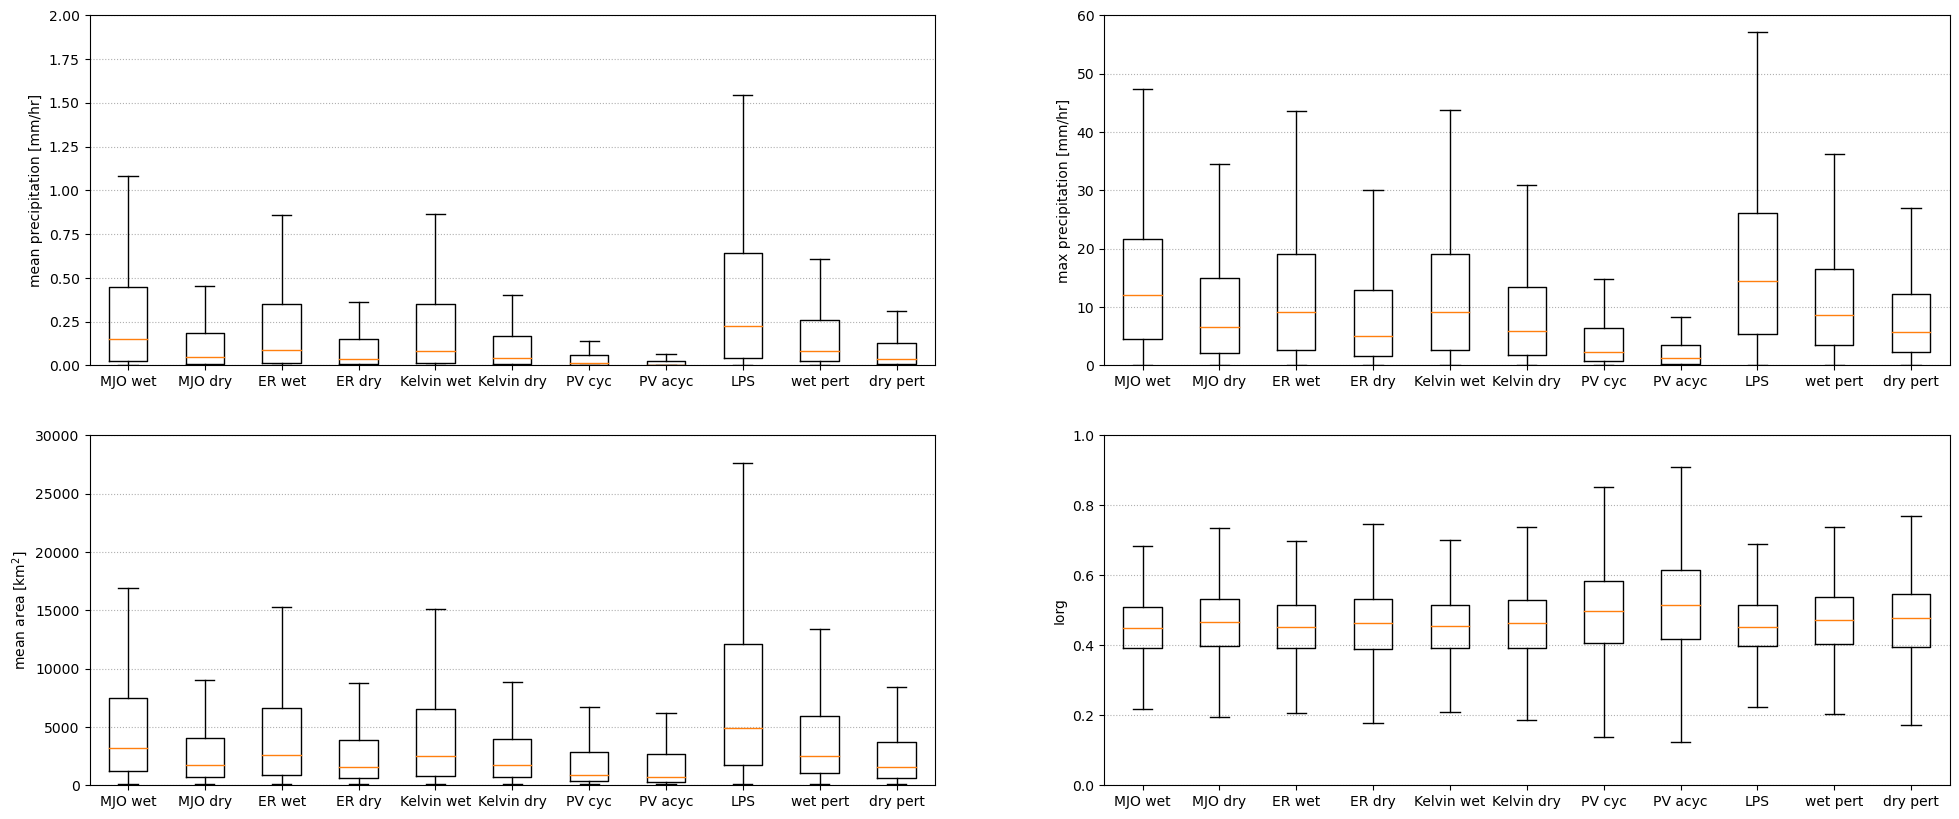

In [49]:
%%time

names = ['MJO wet', 'MJO dry', 'ER wet', 'ER dry', 'Kelvin wet', 'Kelvin dry', 'PV cyc', 'PV acyc', 'LPS', 'wet pert', 'dry pert']

plt.figure(figsize=(24,10))

plt.subplot(221)
plt.boxplot(av_precip_nonan, showfliers=False)
plt.ylabel('mean precipitation [mm/hr]')
plt.ylim(0, 2)
plt.grid(axis='y', linestyle=':')
plt.xticks(np.arange(1, 12), names)

plt.subplot(222)
plt.boxplot(av_maxprecip_nonan, showfliers=False)
plt.ylabel('max precipitation [mm/hr]')
plt.ylim(0, 60)
plt.grid(axis='y', linestyle=':')
plt.xticks(np.arange(1, 12), names)

plt.subplot(223)
plt.boxplot(av_area_nonan, showfliers=False)
plt.ylabel(r'mean area [km$^2$]')
plt.ylim(0, 3e4)
plt.grid(axis='y', linestyle=':')
plt.xticks(np.arange(1, 12), names)

plt.subplot(224)
plt.boxplot(av_Iorg_nonan, showfliers=False)
plt.ylabel('Iorg')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle=':')
plt.xticks(np.arange(1, 12), names)

#plt.savefig('/home/565/cr7888/meso-org/Figures/corey-weather-system-objects.png', bbox_inches='tight', dpi=200)

### Fig 8: stratify organisation by mean rainfall and weather system

For this we need to use data only where both datasets are not NaNs, so filter based on this

In [50]:
wet_pert_av_precip2 = wet_pert_av_precip.where(~wet_pert_av_area.isnull()) # called it something else so I don't overwrite original data
wet_pert_av_area2 = wet_pert_av_area.where(~wet_pert_av_precip2.isnull())
wet_pert_av_precip2_vals = wet_pert_av_precip2.values.ravel()
wet_pert_av_area2_vals = wet_pert_av_area2.values.ravel()
wet_pert_av_precip2_vals = wet_pert_av_precip2_vals[~np.isnan(wet_pert_av_precip2_vals)]
wet_pert_av_area2_vals = wet_pert_av_area2_vals[~np.isnan(wet_pert_av_area2_vals)]

dry_pert_av_precip2 = dry_pert_av_precip.where(~dry_pert_av_area.isnull())
dry_pert_av_area2 = dry_pert_av_area.where(~dry_pert_av_precip2.isnull())
dry_pert_av_precip2_vals = dry_pert_av_precip2.values.ravel()
dry_pert_av_area2_vals = dry_pert_av_area2.values.ravel()
dry_pert_av_precip2_vals = dry_pert_av_precip2_vals[~np.isnan(dry_pert_av_precip2_vals)]
dry_pert_av_area2_vals = dry_pert_av_area2_vals[~np.isnan(dry_pert_av_area2_vals)]

MJO_wet_av_precip2 = MJO_wet_av_precip.where(~MJO_wet_av_area.isnull()) # called it something else so I don't overwrite original data
MJO_wet_av_area2 = MJO_wet_av_area.where(~MJO_wet_av_precip2.isnull())
MJO_wet_av_precip2_vals = MJO_wet_av_precip2.values.ravel()
MJO_wet_av_area2_vals = MJO_wet_av_area2.values.ravel()
MJO_wet_av_precip2_vals = MJO_wet_av_precip2_vals[~np.isnan(MJO_wet_av_precip2_vals)]
MJO_wet_av_area2_vals = MJO_wet_av_area2_vals[~np.isnan(MJO_wet_av_area2_vals)]

MJO_dry_av_precip2 = MJO_dry_av_precip.where(~MJO_dry_av_area.isnull())
MJO_dry_av_area2 = MJO_dry_av_area.where(~MJO_dry_av_precip2.isnull())
MJO_dry_av_precip2_vals = MJO_dry_av_precip2.values.ravel()
MJO_dry_av_area2_vals = MJO_dry_av_area2.values.ravel()
MJO_dry_av_precip2_vals = MJO_dry_av_precip2_vals[~np.isnan(MJO_dry_av_precip2_vals)]
MJO_dry_av_area2_vals = MJO_dry_av_area2_vals[~np.isnan(MJO_dry_av_area2_vals)]


ER_wet_av_precip2 = ER_wet_av_precip.where(~ER_wet_av_area.isnull())
ER_wet_av_area2 = ER_wet_av_area.where(~ER_wet_av_precip2.isnull())
ER_wet_av_precip2_vals = ER_wet_av_precip2.values.ravel()
ER_wet_av_area2_vals = ER_wet_av_area2.values.ravel()
ER_wet_av_precip2_vals = ER_wet_av_precip2_vals[~np.isnan(ER_wet_av_precip2_vals)]
ER_wet_av_area2_vals = ER_wet_av_area2_vals[~np.isnan(ER_wet_av_area2_vals)]

ER_dry_av_precip2 = ER_dry_av_precip.where(~ER_dry_av_area.isnull())
ER_dry_av_area2 = ER_dry_av_area.where(~ER_dry_av_precip2.isnull())
ER_dry_av_precip2_vals = ER_dry_av_precip2.values.ravel()
ER_dry_av_area2_vals = ER_dry_av_area2.values.ravel()
ER_dry_av_precip2_vals = ER_dry_av_precip2_vals[~np.isnan(ER_dry_av_precip2_vals)]
ER_dry_av_area2_vals = ER_dry_av_area2_vals[~np.isnan(ER_dry_av_area2_vals)]


Kelvin_wet_av_precip2 = Kelvin_wet_av_precip.where(~Kelvin_wet_av_area.isnull())
Kelvin_wet_av_area2 = Kelvin_wet_av_area.where(~Kelvin_wet_av_precip2.isnull())
Kelvin_wet_av_precip2_vals = Kelvin_wet_av_precip2.values.ravel()
Kelvin_wet_av_area2_vals = Kelvin_wet_av_area2.values.ravel()
Kelvin_wet_av_precip2_vals = Kelvin_wet_av_precip2_vals[~np.isnan(Kelvin_wet_av_precip2_vals)]
Kelvin_wet_av_area2_vals = Kelvin_wet_av_area2_vals[~np.isnan(Kelvin_wet_av_area2_vals)]

Kelvin_dry_av_precip2 = Kelvin_dry_av_precip.where(~Kelvin_dry_av_area.isnull())
Kelvin_dry_av_area2 = Kelvin_dry_av_area.where(~Kelvin_dry_av_precip2.isnull())
Kelvin_dry_av_precip2_vals = Kelvin_dry_av_precip2.values.ravel()
Kelvin_dry_av_area2_vals = Kelvin_dry_av_area2.values.ravel()
Kelvin_dry_av_precip2_vals = Kelvin_dry_av_precip2_vals[~np.isnan(Kelvin_dry_av_precip2_vals)]
Kelvin_dry_av_area2_vals = Kelvin_dry_av_area2_vals[~np.isnan(Kelvin_dry_av_area2_vals)]


pv_cyc_av_precip2 = pv_cyc_av_precip.where(~pv_cyc_av_area.isnull())
pv_cyc_av_area2 = pv_cyc_av_area.where(~pv_cyc_av_precip2.isnull())
pv_cyc_av_precip2_vals = pv_cyc_av_precip2.values.ravel()
pv_cyc_av_area2_vals = pv_cyc_av_area2.values.ravel()
pv_cyc_av_precip2_vals = pv_cyc_av_precip2_vals[~np.isnan(pv_cyc_av_precip2_vals)]
pv_cyc_av_area2_vals = pv_cyc_av_area2_vals[~np.isnan(pv_cyc_av_area2_vals)]

pv_acyc_av_precip2 = pv_acyc_av_precip.where(~pv_acyc_av_area.isnull())
pv_acyc_av_area2 = pv_acyc_av_area.where(~pv_acyc_av_precip2.isnull())
pv_acyc_av_precip2_vals = pv_acyc_av_precip2.values.ravel()
pv_acyc_av_area2_vals = pv_acyc_av_area2.values.ravel()
pv_acyc_av_precip2_vals = pv_acyc_av_precip2_vals[~np.isnan(pv_acyc_av_precip2_vals)]
pv_acyc_av_area2_vals = pv_acyc_av_area2_vals[~np.isnan(pv_acyc_av_area2_vals)]


LPS_av_precip2 = LPS_av_precip.where(~LPS_av_area.isnull())
LPS_av_area2 = LPS_av_area.where(~LPS_av_precip2.isnull())
LPS_av_precip2_vals = LPS_av_precip2.values.ravel()
LPS_av_area2_vals = LPS_av_area2.values.ravel()
LPS_av_precip2_vals = LPS_av_precip2_vals[~np.isnan(LPS_av_precip2_vals)]
LPS_av_area2_vals = LPS_av_area2_vals[~np.isnan(LPS_av_area2_vals)]

### Create bins for mean precip and calculate average quantities in these bins

In [51]:
def mean_quantity_by_bins(data_x, data_y, bins):

    av_datay = np.zeros((bins.size,1))
    # add infinity as the final bin edge
    bins = np.hstack([bins, np.inf])
    

    for i in range(bins.size - 1):
        lower = bins[i]
        upper = bins[i+1]
        # if i + 1 < bins.size:
            
        # else:
        #     lower = bins[i]
        #     upper = np.inf
            
        mean_indices = (data_x > lower) & (data_x < upper)
    
        filtered = data_y[mean_indices]
        av_datay[i] = filtered.mean()

    return av_datay

In [52]:
mean_precip_bins = np.arange(0.0, 2.6, 0.1)

wet_pert_area_by_avprecip = mean_quantity_by_bins(wet_pert_av_precip2_vals, wet_pert_av_area2_vals, mean_precip_bins)
dry_pert_area_by_avprecip = mean_quantity_by_bins(dry_pert_av_precip2_vals, dry_pert_av_area2_vals, mean_precip_bins)

MJO_wet_area_by_avprecip = mean_quantity_by_bins(MJO_wet_av_precip2_vals, MJO_wet_av_area2_vals, mean_precip_bins)
MJO_dry_area_by_avprecip = mean_quantity_by_bins(MJO_dry_av_precip2_vals, MJO_dry_av_area2_vals, mean_precip_bins)
ER_wet_area_by_avprecip = mean_quantity_by_bins(ER_wet_av_precip2_vals, ER_wet_av_area2_vals, mean_precip_bins)
ER_dry_area_by_avprecip = mean_quantity_by_bins(ER_dry_av_precip2_vals, ER_dry_av_area2_vals, mean_precip_bins)
Kelvin_wet_area_by_avprecip = mean_quantity_by_bins(Kelvin_wet_av_precip2_vals, Kelvin_wet_av_area2_vals, mean_precip_bins)
Kelvin_dry_area_by_avprecip = mean_quantity_by_bins(Kelvin_dry_av_precip2_vals, Kelvin_dry_av_area2_vals, mean_precip_bins)
pv_cyc_area_by_avprecip = mean_quantity_by_bins(pv_cyc_av_precip2_vals, pv_cyc_av_area2_vals, mean_precip_bins)
pv_acyc_area_by_avprecip = mean_quantity_by_bins(pv_acyc_av_precip2_vals, pv_acyc_av_area2_vals, mean_precip_bins)
LPS_area_by_avprecip = mean_quantity_by_bins(LPS_av_precip2_vals, LPS_av_area2_vals, mean_precip_bins)

### Repeat for Iorg

In [53]:
wet_pert_av_precip2 = wet_pert_av_precip.where(~wet_pert_av_Iorg.isnull())
wet_pert_av_Iorg2 = wet_pert_av_Iorg.where(~wet_pert_av_precip2.isnull())
wet_pert_av_precip2_vals = wet_pert_av_precip2.values.ravel()
wet_pert_av_Iorg2_vals = wet_pert_av_Iorg2.values.ravel()
wet_pert_av_precip2_vals = wet_pert_av_precip2_vals[~np.isnan(wet_pert_av_precip2_vals)]
wet_pert_av_Iorg2_vals = wet_pert_av_Iorg2_vals[~np.isnan(wet_pert_av_Iorg2_vals)]

dry_pert_av_precip2 = dry_pert_av_precip.where(~dry_pert_av_Iorg.isnull())
dry_pert_av_Iorg2 = dry_pert_av_Iorg.where(~dry_pert_av_precip2.isnull())
dry_pert_av_precip2_vals = dry_pert_av_precip2.values.ravel()
dry_pert_av_Iorg2_vals = dry_pert_av_Iorg2.values.ravel()
dry_pert_av_precip2_vals = dry_pert_av_precip2_vals[~np.isnan(dry_pert_av_precip2_vals)]
dry_pert_av_Iorg2_vals = dry_pert_av_Iorg2_vals[~np.isnan(dry_pert_av_Iorg2_vals)]

MJO_wet_av_precip2 = MJO_wet_av_precip.where(~MJO_wet_av_Iorg.isnull())
MJO_wet_av_Iorg2 = MJO_wet_av_Iorg.where(~MJO_wet_av_precip2.isnull())
MJO_wet_av_precip2_vals = MJO_wet_av_precip2.values.ravel()
MJO_wet_av_Iorg2_vals = MJO_wet_av_Iorg2.values.ravel()
MJO_wet_av_precip2_vals = MJO_wet_av_precip2_vals[~np.isnan(MJO_wet_av_precip2_vals)]
MJO_wet_av_Iorg2_vals = MJO_wet_av_Iorg2_vals[~np.isnan(MJO_wet_av_Iorg2_vals)]

MJO_dry_av_precip2 = MJO_dry_av_precip.where(~MJO_dry_av_Iorg.isnull())
MJO_dry_av_Iorg2 = MJO_dry_av_Iorg.where(~MJO_dry_av_precip2.isnull())
MJO_dry_av_precip2_vals = MJO_dry_av_precip2.values.ravel()
MJO_dry_av_Iorg2_vals = MJO_dry_av_Iorg2.values.ravel()
MJO_dry_av_precip2_vals = MJO_dry_av_precip2_vals[~np.isnan(MJO_dry_av_precip2_vals)]
MJO_dry_av_Iorg2_vals = MJO_dry_av_Iorg2_vals[~np.isnan(MJO_dry_av_Iorg2_vals)]


ER_wet_av_precip2 = ER_wet_av_precip.where(~ER_wet_av_Iorg.isnull())
ER_wet_av_Iorg2 = ER_wet_av_Iorg.where(~ER_wet_av_precip2.isnull())
ER_wet_av_precip2_vals = ER_wet_av_precip2.values.ravel()
ER_wet_av_Iorg2_vals = ER_wet_av_Iorg2.values.ravel()
ER_wet_av_precip2_vals = ER_wet_av_precip2_vals[~np.isnan(ER_wet_av_precip2_vals)]
ER_wet_av_Iorg2_vals = ER_wet_av_Iorg2_vals[~np.isnan(ER_wet_av_Iorg2_vals)]

ER_dry_av_precip2 = ER_dry_av_precip.where(~ER_dry_av_Iorg.isnull())
ER_dry_av_Iorg2 = ER_dry_av_Iorg.where(~ER_dry_av_precip2.isnull())
ER_dry_av_precip2_vals = ER_dry_av_precip2.values.ravel()
ER_dry_av_Iorg2_vals = ER_dry_av_Iorg2.values.ravel()
ER_dry_av_precip2_vals = ER_dry_av_precip2_vals[~np.isnan(ER_dry_av_precip2_vals)]
ER_dry_av_Iorg2_vals = ER_dry_av_Iorg2_vals[~np.isnan(ER_dry_av_Iorg2_vals)]


Kelvin_wet_av_precip2 = Kelvin_wet_av_precip.where(~Kelvin_wet_av_Iorg.isnull())
Kelvin_wet_av_Iorg2 = Kelvin_wet_av_Iorg.where(~Kelvin_wet_av_precip2.isnull())
Kelvin_wet_av_precip2_vals = Kelvin_wet_av_precip2.values.ravel()
Kelvin_wet_av_Iorg2_vals = Kelvin_wet_av_Iorg2.values.ravel()
Kelvin_wet_av_precip2_vals = Kelvin_wet_av_precip2_vals[~np.isnan(Kelvin_wet_av_precip2_vals)]
Kelvin_wet_av_Iorg2_vals = Kelvin_wet_av_Iorg2_vals[~np.isnan(Kelvin_wet_av_Iorg2_vals)]

Kelvin_dry_av_precip2 = Kelvin_dry_av_precip.where(~Kelvin_dry_av_Iorg.isnull())
Kelvin_dry_av_Iorg2 = Kelvin_dry_av_Iorg.where(~Kelvin_dry_av_precip2.isnull())
Kelvin_dry_av_precip2_vals = Kelvin_dry_av_precip2.values.ravel()
Kelvin_dry_av_Iorg2_vals = Kelvin_dry_av_Iorg2.values.ravel()
Kelvin_dry_av_precip2_vals = Kelvin_dry_av_precip2_vals[~np.isnan(Kelvin_dry_av_precip2_vals)]
Kelvin_dry_av_Iorg2_vals = Kelvin_dry_av_Iorg2_vals[~np.isnan(Kelvin_dry_av_Iorg2_vals)]


pv_cyc_av_precip2 = pv_cyc_av_precip.where(~pv_cyc_av_Iorg.isnull())
pv_cyc_av_Iorg2 = pv_cyc_av_Iorg.where(~pv_cyc_av_precip2.isnull())
pv_cyc_av_precip2_vals = pv_cyc_av_precip2.values.ravel()
pv_cyc_av_Iorg2_vals = pv_cyc_av_Iorg2.values.ravel()
pv_cyc_av_precip2_vals = pv_cyc_av_precip2_vals[~np.isnan(pv_cyc_av_precip2_vals)]
pv_cyc_av_Iorg2_vals = pv_cyc_av_Iorg2_vals[~np.isnan(pv_cyc_av_Iorg2_vals)]

pv_acyc_av_precip2 = pv_acyc_av_precip.where(~pv_acyc_av_Iorg.isnull())
pv_acyc_av_Iorg2 = pv_acyc_av_Iorg.where(~pv_acyc_av_precip2.isnull())
pv_acyc_av_precip2_vals = pv_acyc_av_precip2.values.ravel()
pv_acyc_av_Iorg2_vals = pv_acyc_av_Iorg2.values.ravel()
pv_acyc_av_precip2_vals = pv_acyc_av_precip2_vals[~np.isnan(pv_acyc_av_precip2_vals)]
pv_acyc_av_Iorg2_vals = pv_acyc_av_Iorg2_vals[~np.isnan(pv_acyc_av_Iorg2_vals)]


LPS_av_precip2 = LPS_av_precip.where(~LPS_av_Iorg.isnull())
LPS_av_Iorg2 = LPS_av_Iorg.where(~LPS_av_precip2.isnull())
LPS_av_precip2_vals = LPS_av_precip2.values.ravel()
LPS_av_Iorg2_vals = LPS_av_Iorg2.values.ravel()
LPS_av_precip2_vals = LPS_av_precip2_vals[~np.isnan(LPS_av_precip2_vals)]
LPS_av_Iorg2_vals = LPS_av_Iorg2_vals[~np.isnan(LPS_av_Iorg2_vals)]

In [54]:
wet_pert_Iorg_by_avprecip = mean_quantity_by_bins(wet_pert_av_precip2_vals, wet_pert_av_Iorg2_vals, mean_precip_bins)
dry_pert_Iorg_by_avprecip = mean_quantity_by_bins(dry_pert_av_precip2_vals, dry_pert_av_Iorg2_vals, mean_precip_bins)
MJO_wet_Iorg_by_avprecip = mean_quantity_by_bins(MJO_wet_av_precip2_vals, MJO_wet_av_Iorg2_vals, mean_precip_bins)
MJO_dry_Iorg_by_avprecip = mean_quantity_by_bins(MJO_dry_av_precip2_vals, MJO_dry_av_Iorg2_vals, mean_precip_bins)
ER_wet_Iorg_by_avprecip = mean_quantity_by_bins(ER_wet_av_precip2_vals, ER_wet_av_Iorg2_vals, mean_precip_bins)
ER_dry_Iorg_by_avprecip = mean_quantity_by_bins(ER_dry_av_precip2_vals, ER_dry_av_Iorg2_vals, mean_precip_bins)
Kelvin_wet_Iorg_by_avprecip = mean_quantity_by_bins(Kelvin_wet_av_precip2_vals, Kelvin_wet_av_Iorg2_vals, mean_precip_bins)
Kelvin_dry_Iorg_by_avprecip = mean_quantity_by_bins(Kelvin_dry_av_precip2_vals, Kelvin_dry_av_Iorg2_vals, mean_precip_bins)
pv_cyc_Iorg_by_avprecip = mean_quantity_by_bins(pv_cyc_av_precip2_vals, pv_cyc_av_Iorg2_vals, mean_precip_bins)
pv_acyc_Iorg_by_avprecip = mean_quantity_by_bins(pv_acyc_av_precip2_vals, pv_acyc_av_Iorg2_vals, mean_precip_bins)
LPS_Iorg_by_avprecip = mean_quantity_by_bins(LPS_av_precip2_vals, LPS_av_Iorg2_vals, mean_precip_bins)

### Plot Fig 8 with both mean area and Iorg

Text(0, 0.5, 'Iorg')

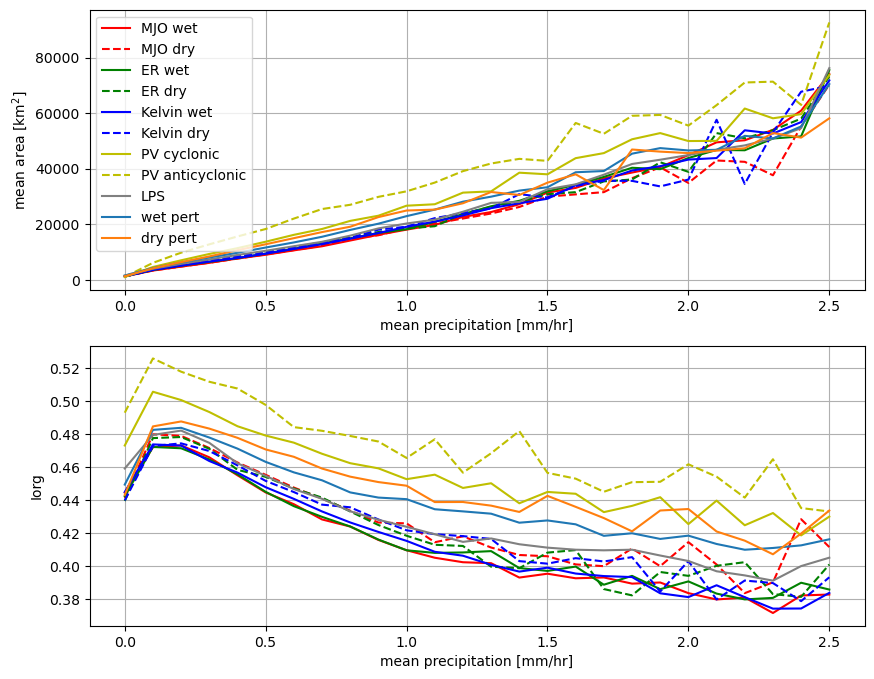

In [56]:
plt.figure(figsize=(10, 8))

plt.subplot(211)
plt.plot(mean_precip_bins, MJO_wet_area_by_avprecip, label='MJO wet', c='r')
plt.plot(mean_precip_bins, MJO_dry_area_by_avprecip, label='MJO dry', c='r', ls='--')
plt.plot(mean_precip_bins, ER_wet_area_by_avprecip, label='ER wet', c='g')
plt.plot(mean_precip_bins, ER_dry_area_by_avprecip, label='ER dry', c='g', ls='--')
plt.plot(mean_precip_bins, Kelvin_wet_area_by_avprecip, label='Kelvin wet', c='b')
plt.plot(mean_precip_bins, Kelvin_dry_area_by_avprecip, label='Kelvin dry', c='b', ls='--')
plt.plot(mean_precip_bins, pv_cyc_area_by_avprecip, label='PV cyclonic', c='y')
plt.plot(mean_precip_bins, pv_acyc_area_by_avprecip, label='PV anticyclonic', c='y', ls='--')
plt.plot(mean_precip_bins, LPS_area_by_avprecip, label='LPS', c='grey')
plt.plot(mean_precip_bins, wet_pert_area_by_avprecip, label='wet pert', c='tab:blue')
plt.plot(mean_precip_bins, dry_pert_area_by_avprecip, label='dry pert', c='tab:orange')
plt.legend()
plt.grid()
plt.xlabel('mean precipitation [mm/hr]')
plt.ylabel(r'mean area [km$^2$]')

plt.subplot(212)
plt.plot(mean_precip_bins, MJO_wet_Iorg_by_avprecip, label='MJO wet', c='r')
plt.plot(mean_precip_bins, MJO_dry_Iorg_by_avprecip, label='MJO dry', c='r', ls='--')
plt.plot(mean_precip_bins, ER_wet_Iorg_by_avprecip, label='ER wet', c='g')
plt.plot(mean_precip_bins, ER_dry_Iorg_by_avprecip, label='ER dry', c='g', ls='--')
plt.plot(mean_precip_bins, Kelvin_wet_Iorg_by_avprecip, label='Kelvin wet', c='b')
plt.plot(mean_precip_bins, Kelvin_dry_Iorg_by_avprecip, label='Kelvin dry', c='b', ls='--')
plt.plot(mean_precip_bins, pv_cyc_Iorg_by_avprecip, label='PV cyclonic', c='y')
plt.plot(mean_precip_bins, pv_acyc_Iorg_by_avprecip, label='PV anticyclonic', c='y', ls='--')
plt.plot(mean_precip_bins, LPS_Iorg_by_avprecip, label='LPS', c='grey')
plt.plot(mean_precip_bins, wet_pert_Iorg_by_avprecip, label='wet pert', c='tab:blue')
plt.plot(mean_precip_bins, dry_pert_Iorg_by_avprecip, label='dry pert', c='tab:orange')
plt.grid()
plt.xlabel('mean precipitation [mm/hr]')
plt.ylabel(r'Iorg')

#plt.savefig('/home/565/cr7888/meso-org/Figures/corey-Fig8.png', bbox_inches='tight', dpi=200)

In [ ]:
assert False

## Alternative method (object-based)

Here the IMERG quantities are evaluated for each object (average over the obect area)

In [ ]:
def object_av_data(tracks, data, times):

    av = np.zeros(tracks.shape[0])

    data_filtered = data.copy()#deep=True)
    data_filtered.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    data_filtered.rio.write_crs("epsg:4326", inplace=True)

    t = 0
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for obj in tracks.iterrows():
            try:
                geom_t = obj[1]['geometry']#tracks.xs(str(time)[:10], level='time')['geometry']
                time = obj[0][0].floor('d')#[1]['time']
                filtered = data_filtered.sel(time=time).rio.clip(gpd.GeoSeries(geom_t), all_touched=True, drop=True)
                filtered_mean = filtered.mean(['latitude', 'longitude'], skipna=True)
                av[t] = filtered_mean
            except KeyError:
                #print('no objects found', t)
                av[t] = np.nan
                #pass
            except: #NoDataInBounds
                av[t] = np.nan
            if t % 1000 == 0: #10000
                print(t)
                #break
            t += 1
    return av


In [ ]:
%%time

MJO_wet_av_precip = object_av_data(MJO_wet_tracks.iloc[:500], pr_based_mean_pr2, times)
MJO_dry_av_precip = object_av_data(MJO_dry_tracks.iloc[:500], pr_based_mean_pr2, times)
ER_wet_av_precip = object_av_data(ER_wet_tracks.iloc[:500], pr_based_mean_pr2, times)
ER_dry_av_precip = object_av_data(ER_dry_tracks.iloc[:500], pr_based_mean_pr2, times)
Kelvin_wet_av_precip = object_av_data(Kelvin_wet_tracks.iloc[:500], pr_based_mean_pr2, times)
Kelvin_dry_av_precip = object_av_data(Kelvin_dry_tracks.iloc[:500], pr_based_mean_pr2, times)

MJO_wet_av_area = object_av_data(MJO_wet_tracks.iloc[:500], pr_based_mean_area2, times)
MJO_dry_av_area = object_av_data(MJO_dry_tracks.iloc[:500], pr_based_mean_area2, times)
ER_wet_av_area = object_av_data(ER_wet_tracks.iloc[:500], pr_based_mean_area2, times)
ER_dry_av_area = object_av_data(ER_dry_tracks.iloc[:500], pr_based_mean_area2, times)
Kelvin_wet_av_area = object_av_data(Kelvin_wet_tracks.iloc[:500], pr_based_mean_area2, times)
Kelvin_dry_av_area = object_av_data(Kelvin_dry_tracks.iloc[:500], pr_based_mean_area2, times)

MJO_wet_av_maxprecip = object_av_data(MJO_wet_tracks.iloc[:500], pr_based_max_pr_30min2, times)
MJO_dry_av_maxprecip = object_av_data(MJO_dry_tracks.iloc[:500], pr_based_max_pr_30min2, times)
ER_wet_av_maxprecip = object_av_data(ER_wet_tracks.iloc[:500], pr_based_max_pr_30min2, times)
ER_dry_av_maxprecip = object_av_data(ER_dry_tracks.iloc[:500], pr_based_max_pr_30min2, times)
Kelvin_wet_av_maxprecip = object_av_data(Kelvin_wet_tracks.iloc[:500], pr_based_max_pr_30min2, times)
Kelvin_dry_av_maxprecip = object_av_data(Kelvin_dry_tracks.iloc[:500], pr_based_max_pr_30min2, times)

MJO_wet_av_Iorg = object_av_data(MJO_wet_tracks.iloc[:500], pr_based_Iorg2, times)
MJO_dry_av_Iorg = object_av_data(MJO_dry_tracks.iloc[:500], pr_based_Iorg2, times)
ER_wet_av_Iorg = object_av_data(ER_wet_tracks.iloc[:500], pr_based_Iorg2, times)
ER_dry_av_Iorg = object_av_data(ER_dry_tracks.iloc[:500], pr_based_Iorg2, times)
Kelvin_wet_av_Iorg = object_av_data(Kelvin_wet_tracks.iloc[:500], pr_based_Iorg2, times)
Kelvin_dry_av_Iorg = object_av_data(Kelvin_dry_tracks.iloc[:500], pr_based_Iorg2, times)

MJO_wet_av_precip

In [ ]:
def object_av_data_expand(tracks, data, times, expand):

    av = np.zeros(tracks.shape[0])

    data_filtered = data.copy()#deep=True)
    data_filtered.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    data_filtered.rio.write_crs("epsg:4326", inplace=True)

    t = 0
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for obj in tracks.iterrows():
            try:
                geom_t = obj[1]['geometry']
                geom_t = geom_t.buffer(expand)# expend geometry
                time = obj[0][0].floor('d')#[1]['time']
                filtered = data_filtered.sel(time=time).rio.clip(gpd.GeoSeries(geom_t), all_touched=True, drop=True)
                filtered_mean = filtered.mean(['latitude', 'longitude'], skipna=True)
                av[t] = filtered_mean
            except KeyError:
                #print('no objects found', t)
                av[t] = np.nan
                #pass
            except: #NoDataInBounds
                av[t] = np.nan
            if t % 1000 == 0: #10000
                print(t)
                #break
            t += 1
    return av


In [ ]:
%%time

pv_cyc_av_precip = object_av_data_expand(pv_cyc_350K_tracks.iloc[:500], pr_based_mean_pr2, times, expand=5)
pv_acyc_av_precip = object_av_data_expand(pv_acyc_350K_tracks.iloc[:500], pr_based_mean_pr2, times, expand=5)

pv_cyc_av_area = object_av_data_expand(pv_cyc_350K_tracks.iloc[:500], pr_based_mean_area2, times, expand=5)
pv_acyc_av_area = object_av_data_expand(pv_acyc_350K_tracks.iloc[:500], pr_based_mean_area2, times, expand=5)

pv_cyc_av_maxprecip = object_av_data_expand(pv_cyc_350K_tracks.iloc[:500], pr_based_max_pr_30min2, times, expand=5)
pv_acyc_av_maxprecip = object_av_data_expand(pv_acyc_350K_tracks.iloc[:500], pr_based_max_pr_30min2, times, expand=5)

pv_cyc_av_Iorg = object_av_data_expand(pv_cyc_350K_tracks.iloc[:500], pr_based_Iorg2, times, expand=5)
pv_acyc_av_Iorg = object_av_data_expand(pv_acyc_350K_tracks.iloc[:500], pr_based_Iorg2, times, expand=5)


### ...and for point based LPS objects

In [ ]:
def object_av_data_point(tracks, data, times, expand):

    av = np.zeros(tracks.shape[0])

    data_filtered = data.copy()#deep=True)
    data_filtered.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    data_filtered.rio.write_crs("epsg:4326", inplace=True)

    t = 0
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        
        for obj in tracks.iterrows():
            try:
                lon_t, lat_t = obj[1]['lon'], obj[1]['lat']
                #print(lon_t, lat_t)
                geom_t = Point(lon_t, lat_t) #, crs='epsg:4326'
                
                geom_t = geom_t.buffer(expand)# expand geometry
                
                time = obj[0][1].floor('d')#[1]['time']
                filtered = data_filtered.sel(time=time).rio.clip(gpd.GeoSeries(geom_t), all_touched=True, drop=True)
                filtered_mean = filtered.mean(['latitude', 'longitude'], skipna=True)
                av[t] = filtered_mean
            except KeyError:
                print('no objects found', t)
                av[t] = np.nan
                #pass
            except: #NoDataInBounds
                av[t] = np.nan
            if t % 1000 == 0: #10000
                print(t)
                #break
            t += 1
    return av


In [ ]:
thingo = LPS_df.reset_index()
thingo = thingo[thingo['time'] >= '2001-01-01'].set_index(['id', 'time'])
thingo

In [ ]:
%%time

LPS_av_precip = object_av_data_point(thingo.iloc[:500], pr_based_mean_pr2, times, expand=5)
LPS_av_area = object_av_data_point(thingo.iloc[:500], pr_based_mean_area2, times, expand=5)
LPS_av_maxprecip = object_av_data_point(thingo.iloc[:500], pr_based_max_pr_30min2, times, expand=5)
LPS_av_Iorg = object_av_data_point(thingo.iloc[:500], pr_based_Iorg2, times, expand=5)


In [ ]:
MJO_wet_av_precip_nonan = MJO_wet_av_precip[~np.isnan(MJO_wet_av_precip)]
MJO_dry_av_precip_nonan = MJO_dry_av_precip[~np.isnan(MJO_dry_av_precip)]
ER_wet_av_precip_nonan = ER_wet_av_precip[~np.isnan(ER_wet_av_precip)]
ER_dry_av_precip_nonan = ER_dry_av_precip[~np.isnan(ER_dry_av_precip)]
Kelvin_wet_av_precip_nonan = Kelvin_wet_av_precip[~np.isnan(Kelvin_wet_av_precip)]
Kelvin_dry_av_precip_nonan = Kelvin_dry_av_precip[~np.isnan(Kelvin_dry_av_precip)]
pv_cyc_av_precip_nonan = pv_cyc_av_precip[~np.isnan(pv_cyc_av_precip)]
pv_acyc_av_precip_nonan = pv_acyc_av_precip[~np.isnan(pv_acyc_av_precip)]
LPS_av_precip_nonan = LPS_av_precip[~np.isnan(LPS_av_precip)]

av_precip_nonan = [MJO_wet_av_precip_nonan, MJO_dry_av_precip_nonan, ER_wet_av_precip_nonan, 
                   ER_dry_av_precip_nonan, Kelvin_wet_av_precip_nonan, Kelvin_dry_av_precip_nonan,
                  pv_cyc_av_precip_nonan, pv_acyc_av_precip_nonan, LPS_av_precip_nonan]


MJO_wet_av_maxprecip_nonan = MJO_wet_av_maxprecip[~np.isnan(MJO_wet_av_maxprecip)]
MJO_dry_av_maxprecip_nonan = MJO_dry_av_maxprecip[~np.isnan(MJO_dry_av_maxprecip)]
ER_wet_av_maxprecip_nonan = ER_wet_av_maxprecip[~np.isnan(ER_wet_av_maxprecip)]
ER_dry_av_maxprecip_nonan = ER_dry_av_maxprecip[~np.isnan(ER_dry_av_maxprecip)]
Kelvin_wet_av_maxprecip_nonan = Kelvin_wet_av_maxprecip[~np.isnan(Kelvin_wet_av_maxprecip)]
Kelvin_dry_av_maxprecip_nonan = Kelvin_dry_av_maxprecip[~np.isnan(Kelvin_dry_av_maxprecip)]
pv_cyc_av_maxprecip_nonan = pv_cyc_av_maxprecip[~np.isnan(pv_cyc_av_maxprecip)]
pv_acyc_av_maxprecip_nonan = pv_acyc_av_maxprecip[~np.isnan(pv_acyc_av_maxprecip)]
LPS_av_maxprecip_nonan = LPS_av_maxprecip[~np.isnan(LPS_av_maxprecip)]

av_maxprecip_nonan = [MJO_wet_av_maxprecip_nonan, MJO_dry_av_maxprecip_nonan, ER_wet_av_maxprecip_nonan, 
                   ER_dry_av_maxprecip_nonan, Kelvin_wet_av_maxprecip_nonan, Kelvin_dry_av_maxprecip_nonan,
                  pv_cyc_av_maxprecip_nonan, pv_acyc_av_maxprecip_nonan, LPS_av_maxprecip_nonan]


MJO_wet_av_area_nonan = MJO_wet_av_area[~np.isnan(MJO_wet_av_area)]
MJO_dry_av_area_nonan = MJO_dry_av_area[~np.isnan(MJO_dry_av_area)]
ER_wet_av_area_nonan = ER_wet_av_area[~np.isnan(ER_wet_av_area)]
ER_dry_av_area_nonan = ER_dry_av_area[~np.isnan(ER_dry_av_area)]
Kelvin_wet_av_area_nonan = Kelvin_wet_av_area[~np.isnan(Kelvin_wet_av_area)]
Kelvin_dry_av_area_nonan = Kelvin_dry_av_area[~np.isnan(Kelvin_dry_av_area)]
pv_cyc_av_area_nonan = pv_cyc_av_area[~np.isnan(pv_cyc_av_area)]
pv_acyc_av_area_nonan = pv_acyc_av_area[~np.isnan(pv_acyc_av_area)]
LPS_av_area_nonan = LPS_av_area[~np.isnan(LPS_av_area)]

av_area_nonan = [MJO_wet_av_area_nonan, MJO_dry_av_area_nonan, ER_wet_av_area_nonan, 
                   ER_dry_av_area_nonan, Kelvin_wet_av_area_nonan, Kelvin_dry_av_area_nonan,
                  pv_cyc_av_area_nonan, pv_acyc_av_area_nonan, LPS_av_area_nonan]



MJO_wet_av_Iorg_nonan = MJO_wet_av_Iorg[~np.isnan(MJO_wet_av_Iorg)]
MJO_dry_av_Iorg_nonan = MJO_dry_av_Iorg[~np.isnan(MJO_dry_av_Iorg)]
ER_wet_av_Iorg_nonan = ER_wet_av_Iorg[~np.isnan(ER_wet_av_Iorg)]
ER_dry_av_Iorg_nonan = ER_dry_av_Iorg[~np.isnan(ER_dry_av_Iorg)]
Kelvin_wet_av_Iorg_nonan = Kelvin_wet_av_Iorg[~np.isnan(Kelvin_wet_av_Iorg)]
Kelvin_dry_av_Iorg_nonan = Kelvin_dry_av_Iorg[~np.isnan(Kelvin_dry_av_Iorg)]
pv_cyc_av_Iorg_nonan = pv_cyc_av_Iorg[~np.isnan(pv_cyc_av_Iorg)]
pv_acyc_av_Iorg_nonan = pv_acyc_av_Iorg[~np.isnan(pv_acyc_av_Iorg)]
LPS_av_Iorg_nonan = LPS_av_Iorg[~np.isnan(LPS_av_Iorg)]

av_Iorg_nonan = [MJO_wet_av_Iorg_nonan, MJO_dry_av_Iorg_nonan, ER_wet_av_Iorg_nonan, 
                   ER_dry_av_Iorg_nonan, Kelvin_wet_av_Iorg_nonan, Kelvin_dry_av_Iorg_nonan,
                  pv_cyc_av_Iorg_nonan, pv_acyc_av_Iorg_nonan, LPS_av_Iorg_nonan]

names = ['MJO wet', 'MJO dry', 'ER wet', 'ER dry', 'Kelvin wet', 'Kelvin dry', 'PV cyc', 'PV acyc', 'LPS']

In [ ]:
%%time

plt.figure(figsize=(20,10))

plt.subplot(221)
plt.boxplot(av_precip_nonan, showfliers=False)
plt.ylabel('mean precipitation [mm/hr]')
plt.ylim(0, 1.5)
plt.grid(axis='y', linestyle=':')
plt.xticks(np.arange(1, 10), names)

plt.subplot(222)
plt.boxplot(av_maxprecip_nonan, showfliers=False)
plt.ylabel('max precipitation [mm/hr]')
plt.ylim(0, 50)
plt.grid(axis='y', linestyle=':')
plt.xticks(np.arange(1, 10), names)

plt.subplot(223)
plt.boxplot(av_area_nonan, showfliers=False)
plt.ylabel(r'mean area [km$^2$]')
plt.ylim(0, 2.5e4)
plt.grid(axis='y', linestyle=':')
plt.xticks(np.arange(1, 10), names)

plt.subplot(224)
plt.boxplot(av_Iorg_nonan, showfliers=False)
plt.ylabel('Iorg')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle=':')
plt.xticks(np.arange(1, 10), names)